# Analysis of optimal scenarios agaisnt other scenarios

In [3]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetup
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario
import seaborn as sns
import datetime
import pickle

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']

nnodes = 107  # nodes

# Horizon for each problem
ndays = 90
when = 'future'

setup = ItalySetup(nnodes, ndays)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'model_output/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)

Loaded Italy Setup with 107 nodes.


In [4]:

outdir = 'model_output/'
file_prefix = f'scnMaxVacc4000short'
mvr = 4000
scn_results = pd.DataFrame(columns=['total_vacc', 'method', 'infected'])
methods = ['opt', 'int', 'inc', 'pop']
for met in methods:
    scn_maxvacc = [1e6, 4e6, 8e6, 12e6, 16e6, 20e6]
    for scn_id, scn_maxvacc in enumerate(scn_maxvacc):
        md = pd.read_csv(f'{outdir}{file_prefix}-{met}{nnodes}-r{mvr}-m{int(scn_maxvacc)}.csv', index_col= 'date', parse_dates=True)
        infected = md[md['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R'])]['value'].sum()
        scn_results = pd.concat([scn_results, pd.DataFrame.from_dict({'total_vacc':[int(scn_maxvacc)],
                                                                      'method': [met],
                                                                      'infected':[infected]
                                                                     })])
                                
                    
    md = pd.read_csv(f'{outdir}{file_prefix}-int{nnodes}-r0-m0.csv', index_col= 'date', parse_dates=True)
    infected = md[md['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R'])]['value'].sum()
    scn_results = pd.concat([scn_results, pd.DataFrame.from_dict({'total_vacc':[int(0)],
                                                                          'method': [met],
                                                                          'infected':[infected]
                                                                         })])
    scn_results['averted'] = max(scn_results['infected']) - scn_results['infected']                                       

In [169]:
def generate_alternatives(no_vacc):
    
    
    ndays = 45  # 'full'
    use_matlab = False

    n_int_steps = 1

    setup = ItalySetup(nnodes, ndays)
    M = setup.nnodes
    N = len(setup.model_days) - 1
    scn_maxvacc = [1e6, 4e6, 8e6, 12e6, 16e6, 20e6]
    # BY INCIDENCE: 
    incid = no_vacc[no_vacc['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R'])].groupby('placeID').sum()
    incid.sort_values('value', ascending=False)
    for scn_id, scn_maxvacc in enumerate(scn_maxvacc):
        control_initial = np.zeros((M, N))
        max_vacc_rate = np.zeros((M, N))
        allocated_total = 0
        unvac_nd = np.copy(setup.pop_node)

        for nd in incid.sort_values('value', ascending=False).index:
            for k in range(N):
                max_vacc_rate[nd, k] = mvr
                if (allocated_total + mvr < scn_maxvacc) and (unvac_nd[nd] - mvr > 0):
                    control_initial[nd, k] = mvr
                    allocated_total += mvr
                    unvac_nd[nd] -= mvr

        results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                          setup=setup,
                                                                          parameters=p,
                                                                          controls=control_initial,
                                                                          save_to=f'{outdir}{file_prefix}-inc{nnodes}-r{mvr}-m{int(scn_maxvacc)}',
                                                                          n_rk4_steps=n_int_steps)
    scn_maxvacc = [1e6, 4e6, 8e6, 12e6, 16e6, 20e6]
    # BY POPULATION 
    for scn_id, scn_maxvacc in enumerate(scn_maxvacc):
        control_initial = np.zeros((M, N))
        max_vacc_rate = np.zeros((M, N))
        allocated_total = 0
        unvac_nd = np.copy(setup.pop_node)

        for nd in reversed(np.argsort(setup.pop_node)):
            for k in range(N):
                max_vacc_rate[nd, k] = mvr
                if (allocated_total + mvr < scn_maxvacc) and (unvac_nd[nd] - mvr > 0):
                    control_initial[nd, k] = mvr
                    allocated_total += mvr
                    unvac_nd[nd] -= mvr

        results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                          setup=setup,
                                                                          parameters=p,
                                                                          controls=control_initial,
                                                                          save_to=f'{outdir}{file_prefix}-pop{nnodes}-r{mvr}-m{int(scn_maxvacc)}',
                                                                          n_rk4_steps=n_int_steps)

    

generate_alternatives(mydata['0'])

 11%|█         | 5/45 [00:00<00:00, 48.53it/s]

Loaded Italy Setup with 107 nodes.
===> Integrating for model_output/scnMaxVacc4000short-inc107-r4000-m1000000


 11%|█         | 5/45 [00:00<00:00, 46.47it/s]

===> Integrating for model_output/scnMaxVacc4000short-inc107-r4000-m4000000


 11%|█         | 5/45 [00:00<00:00, 49.68it/s]

===> Integrating for model_output/scnMaxVacc4000short-inc107-r4000-m8000000


 11%|█         | 5/45 [00:00<00:00, 49.12it/s]

===> Integrating for model_output/scnMaxVacc4000short-inc107-r4000-m12000000


 11%|█         | 5/45 [00:00<00:00, 47.17it/s]

===> Integrating for model_output/scnMaxVacc4000short-inc107-r4000-m16000000


 13%|█▎        | 6/45 [00:00<00:00, 52.24it/s]

===> Integrating for model_output/scnMaxVacc4000short-inc107-r4000-m20000000


 11%|█         | 5/45 [00:00<00:00, 47.10it/s]

===> Integrating for model_output/scnMaxVacc4000short-pop107-r4000-m1000000


 13%|█▎        | 6/45 [00:00<00:00, 51.02it/s]

===> Integrating for model_output/scnMaxVacc4000short-pop107-r4000-m4000000


 11%|█         | 5/45 [00:00<00:00, 45.26it/s]

===> Integrating for model_output/scnMaxVacc4000short-pop107-r4000-m8000000


 13%|█▎        | 6/45 [00:00<00:00, 51.24it/s]

===> Integrating for model_output/scnMaxVacc4000short-pop107-r4000-m12000000


 11%|█         | 5/45 [00:00<00:00, 49.05it/s]

===> Integrating for model_output/scnMaxVacc4000short-pop107-r4000-m16000000


 11%|█         | 5/45 [00:00<00:00, 45.16it/s]

===> Integrating for model_output/scnMaxVacc4000short-pop107-r4000-m20000000


100%|██████████| 45/45 [00:00<00:00, 50.14it/s]


In [170]:
no_vacc = mydata['0']

In [161]:
sort_index = 

In [162]:
sort_index

array([ 93,   6,  30,  56,  94, 102, 101,  85,   1, 104, 100,  95,  13,
        44,  76,  24,  43,  90,   7,   4,  10,  69,  52,  54,  97,  31,
        28,  99,  84,  51,   8,  61,  32,  46,  65,  66,  92,  42,  55,
        67,  87,  48,  96,  98,  50,  37, 106,  78,  40,  18,  75,   2,
        68,  45,  38, 105,  73,  39,  88,  19,  63,  49,   5,  80,  91,
        83,  33,  41,  59,  89,  29,  20,  34,  21,  17,  79,  58,  72,
         3,  12,  70,  82,  53,  35,  77,  74,   9,  26,  23, 103,  25,
        11,  60,  22,  27,  47,  36,  64,  86,  15,  71,  81,  16,   0,
        62,  14,  57])

In [201]:
scn_results.pivot(index='total_vacc', columns='method', values = 'averted')

method,inc,int,opt
total_vacc,,,
0,0.000000,NaN,NaN
1000000,140463.463519,106678.069718,219896.314518
4000000,293504.795198,283999.690950,374984.977402
8000000,386298.501396,388854.140371,430562.483795
12000000,426446.245197,433200.094894,446821.843431
16000000,445240.184858,448620.237205,450845.116567
20000000,450188.910261,450188.910261,451359.596494


In [255]:
scn_results.replace('opt', 'Optimal', inplace=True)
scn_results.replace('int', 'Uniform', inplace=True)
scn_results.replace('inc', 'Incidence', inplace=True)
scn_results.replace('pop', 'Population', inplace=True)

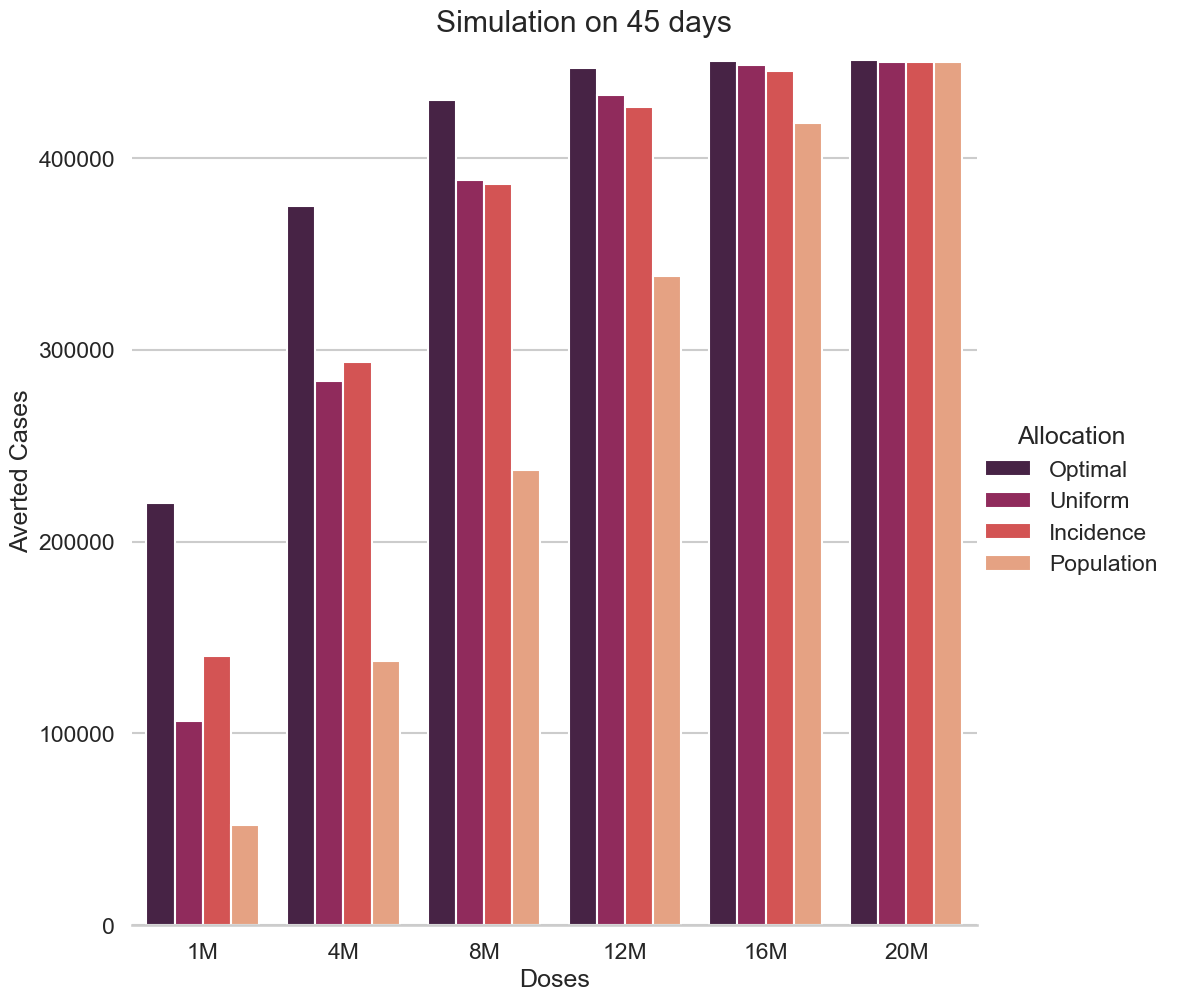

In [292]:
ndays = 45
#fig, ax = plt.subplots(figsize=(10,10))
sns.set(rc={'figure.figsize':(10,10), 'figure.dpi':100})
sns.set_theme(style="whitegrid")
sns.set_context("talk")
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=scn_results[scn_results['total_vacc'] > 0], kind="bar",
    x="total_vacc", y="averted", hue="method",
    palette="rocket",
    #alpha=.9, 
    height=10,
)
g.despine(left=True)
g.fig.suptitle(f'Simulation on {ndays} days')
g.set_axis_labels("Doses", "Averted Cases")
g.legend.set_title("Allocation")
g.set_xticklabels(['1M', '4M', '8M', '12M', '16M', '20M'])


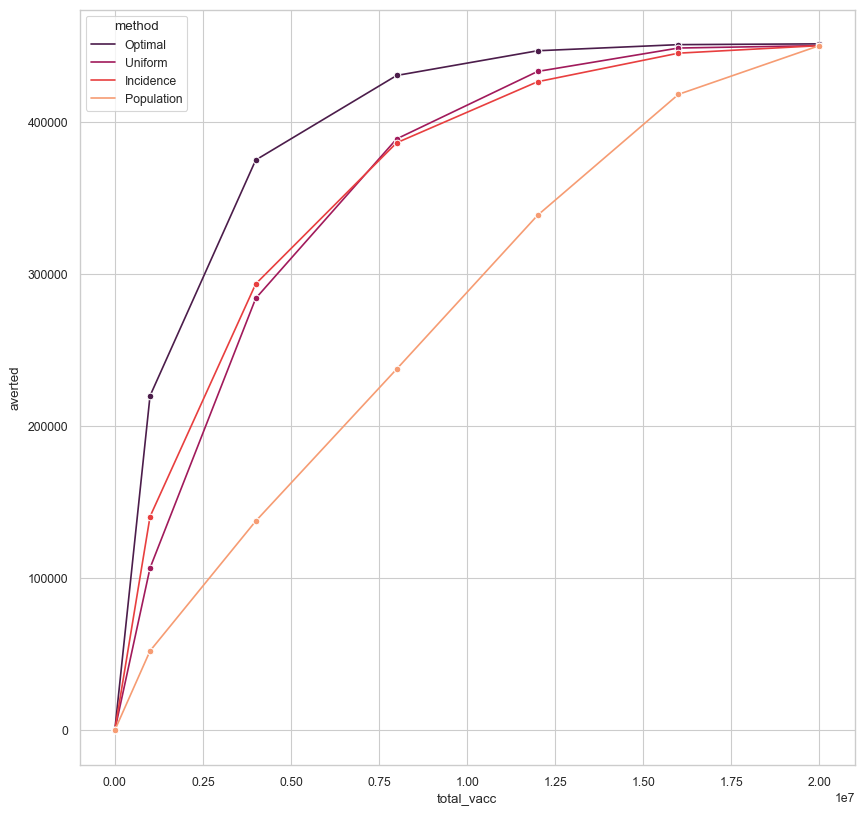

In [288]:
g = sns.lineplot(
    data=scn_results, 
    x="total_vacc", y="averted", hue="method",
    palette="rocket", marker = 'o', 
    #alpha=.9, 
)

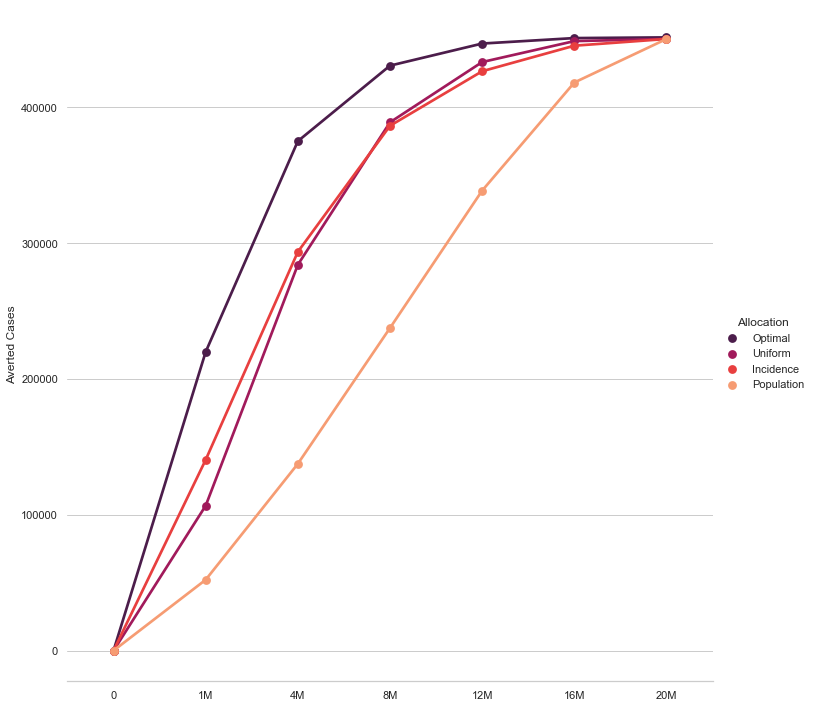

In [257]:
g = sns.catplot(
    data=scn_results, kind="point",
    x="total_vacc", y="averted", hue="method",
    palette="rocket",
    #alpha=.9, 
    height=10,
)
g.despine(left=True)
g.set_axis_labels("", "Averted Cases")
g.legend.set_title("Allocation")
g.set_xticklabels(['0', '1M', '4M', '8M', '12M', '16M', '20M'])